Looking at survival rates in PR lifetimes.

## Survival Analysis

Survival analysis works by considering *censored* time data - that is, data
where one end of the time range is unknown.

Frequently this is medical data. For example, a study on the survival of
patients after an operation may run for 2 years, and patients that die in the 2
year span have an exactly known survival time - but those that survive exit the
study, and we only know that they lived *at least* years post-operation. This is
*right-censored* data.

With a change of framing, this works for PRs and Issues. If we consider all PRs to
start at t=0, then *today* there are closed PRs with known ranges, and open PRs
which have been open *at least* X days (where X = now - creation-time)

Here's how this looks in practice. Here I'm going to use `R 4.1`, the
[`ggsurvminer`](https://cran.r-project.org/web/packages/survminer/readme/README.html)
package, and plot a simple [Kaplan-Meier
curve](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator) for speed -
better estimates will probably be relevant if we go down this road.

In [2]:
# Libraries and data
knitr::opts_chunk$set(echo = TRUE)
library(tidyverse)
library(dbplyr)
library(lubridate)
library(RPostgreSQL)
library(config)
library(survminer)
library(survival)

m   <- DBI::dbDriver("PostgreSQL")
con <- DBI::dbConnect(m,
                      user=config::get('user'),
                      password=config::get('password'),
                      dbname=config::get('database'),
                      host=config::get('host')
)

augur_id <- con %>%
  tbl(in_schema("augur_data", "repo")) %>%
  filter(repo_git == 'https://github.com/chaoss/augur') %>%
  pull(repo_id)

con %>%
  tbl(in_schema("augur_data", "pull_requests")) %>%
  filter(repo_id == augur_id) %>% collect() -> prs
nrow(prs)
con %>%
  tbl(in_schema("augur_data", "issues")) %>%
  filter(repo_id == augur_id) %>% collect() -> issues
nrow(issues)

[1] 1066

[1] 1468

We need just 2 columns for a no-regressors survival analysis - the time, and the state (alive/dead or open/closed in our case). We'll add in both Issues and PRs to illustrate a single-dimension of strata

In [3]:
prs %>%
  # survival looks for an "event" which here is the closing of the PR
  transmute(type = 'PR',
            event = as.integer(!is.na(pr_closed_at)),
            start = ymd_hms(pr_created_at),
            end   = ymd_hms(pr_closed_at),
            time  = case_when(
              is.na(end) ~ Sys.time() - start,
              TRUE       ~ end - start
            ) %>% as.numeric(time, units = 'days')
  ) -> prs_df
head(prs_df)

issues %>%
  filter(is.na(pull_request)) %>% # PRs *are* issues to GH
  # survival looks for an "event" which here is the closing of the PR
  transmute(type = 'Issue',
            event = as.integer(!is.na(closed_at)),
            start = ymd_hms(created_at),
            end   = ymd_hms(closed_at),
            time  = case_when(
              is.na(end) ~ Sys.time() - start,
              TRUE       ~ end - start
            ) %>% as.numeric(time, units = 'days')
  ) -> issues_df
head(issues_df)

df <- rbind(prs_df, issues_df)
count(df, type,event)

type,event,start,end,time
<chr>,<int>,<dttm>,<dttm>,<dbl>
PR,1,2020-05-20 16:23:11,2020-05-20 16:23:29,0.0002083333
PR,1,2020-05-29 17:46:46,2020-05-29 17:55:47,0.0062615741
PR,1,2020-11-23 15:05:42,2020-11-23 15:26:03,0.0141319444
PR,1,2020-11-23 16:22:25,2020-11-23 16:23:12,0.0005439815
PR,1,2020-11-23 16:23:50,2020-11-23 19:15:00,0.1188657407
PR,1,2020-11-23 19:53:22,2020-11-23 19:54:06,0.0005092593


type,event,start,end,time
<chr>,<int>,<dttm>,<dttm>,<dbl>
Issue,0,2021-10-11 17:31:41,NA,2.84531366
Issue,0,2021-10-09 05:56:55,NA,5.32779051
Issue,0,2021-09-15 19:02:59,NA,28.78191088
Issue,1,2021-08-30 03:50:22,2021-10-13 15:57:19,44.50482639
Issue,1,2021-08-19 18:19:01,2021-08-19 18:36:29,0.01212963
Issue,0,2021-08-16 23:07:55,NA,58.61181829


type,event,n
<chr>,<int>,<int>
Issue,0,48
Issue,1,356
PR,0,5
PR,1,1061


Now we can generate a KM curve:

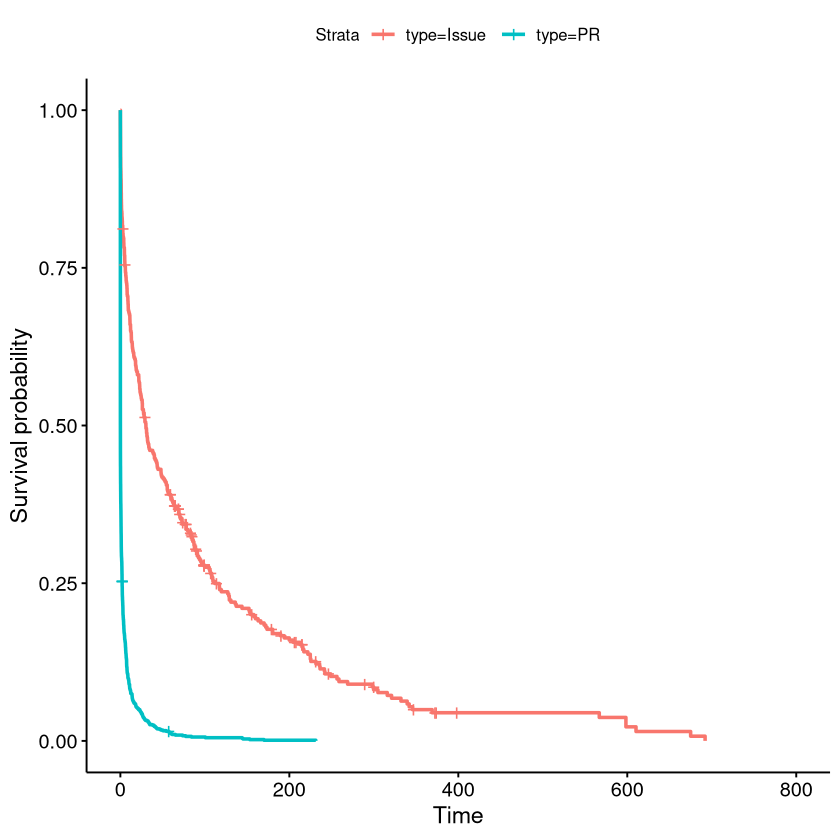

In [4]:
fit <- survfit(Surv(time, event) ~ type, data = df)
ggsurvplot(fit)

"Survival probability" isn't so intuitive, but it's the probably that a PR/Issue "survives", i.e. that it is still open after X days. We can improve this image:

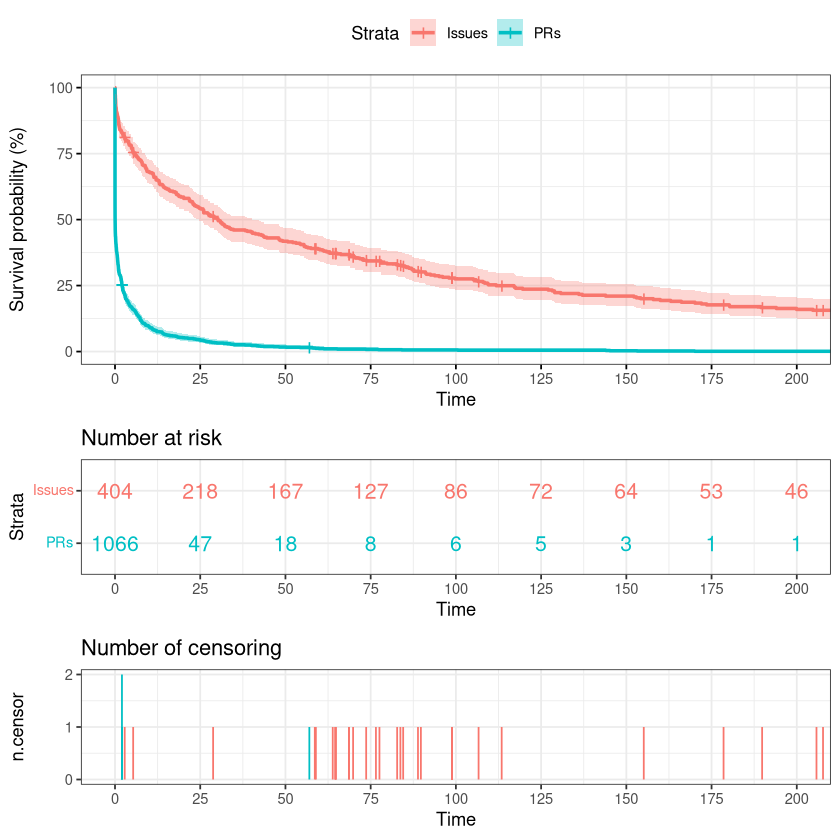

In [5]:
ggsurvplot(
  fit, 
  data = df, 
  fun = 'pct',              # Plot percentages
  size = 1,                 # change line size
  xlim = c(0,200),          # size limit on X
  break.x.by = 25,          # X-axis minor ticks
  conf.int = TRUE,          # Add confidence interval
  risk.table = TRUE,        # Add risk table
  risk.table.col = "strata",# Risk table color by groups
  legend.labs = c("Issues","PRs"),    # Change legend labels
  risk.table.height = 0.25, # Useful to change when you have multiple groups
  ncensor.plot = TRUE,      # plot the number of censored subjects at time t
  ggtheme = theme_bw()      # Change ggplot2 theme
)

We can see that the "average" (median, at 50% on Y) is very small for PRs, and this is what you would see if you just take a median directly:

In [6]:
df %>%
  group_by(type) %>%
  summarise(median = median(time))

type,median
<chr>,<dbl>
Issue,29.49601273
PR,0.03210648


30 days for Issues, 0.03 days (46 mins) for PRs - very fast! But do we want just half of our community to experience a fast time?

One of the big advantages of Survival Analysis for me is that we can pick another value - say, 25%, implying a 75% chance of closing. That tells a different story:

In [7]:
fit %>%
  survminer::surv_summary(data = df) %>%
  group_by(type) %>%
  filter(surv < 0.25) %>%
  summarise(time = first(time))

type,time
<fct>,<dbl>
Issue,111.821435
PR,2.080938


Now it's 112 days for Issues and 2 days for PRs - still good, but very different to the 46 minutes we saw for the median (the mean will likely be even further out).

Visually, we can gain an intuition for these curves. For a fast merge/close process, we want the survival to drop as low as possible, as quickly as possible - i.e we want a shape like the PRs curve, not like the Issues curve. This graphical view of the time-to-merge data is very helpful, once you get used to it.

This can also be used for other time data - time to first comment, time to return for new contributors, etc.